<a href="https://colab.research.google.com/github/Pratik2222/Projects/blob/main/Categorize_Penguins_By_Species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###To train a machine learning model with a custom training loop to categorize penguins by species

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Setup

In [2]:
!pip install -q tfds-nightly

In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

TensorFlow version: 2.8.2
TensorFlow Datasets version:  4.6.0+nightly


####1. Import a Tensor Dataset

In [4]:
# There are 344 data records in this dataset. 
# Extract the first five records into a DataFrame object to inspect a sample of the values in this dataset:

ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': tf.float32,
    'culmen_depth_mm': tf.float32,
    'culmen_length_mm': tf.float32,
    'flipper_length_mm': tf.float32,
    'island': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})


In the dataset, the label for the penguin species is represented as a number to make it easier to work with in the model you are building. 
These numbers correspond to the following penguin species:

`0: Adélie penguin` \
`1: Chinstrap penguin` \
`2: Gentoo penguin`

In [5]:
# Creating a list containing the penguin species names in this order. 
# We used this list to interpret the output of the classification model:

class_names = ['Adélie', 'Chinstrap', 'Gentoo']

###### Download the preprocessed dataset

In [6]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("\nTrain dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

FeaturesDict({
    'features': Tensor(shape=(4,), dtype=tf.float32),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2

Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 0.3559322, 0.41666666]        0


In [7]:
ds_train_batch

<BatchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

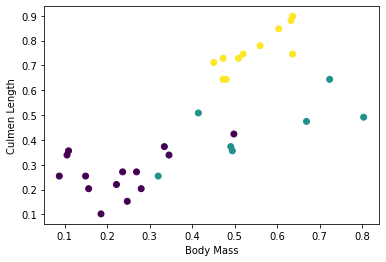

In [9]:
#Visualize some clusters by plotting a few features from the batch:

plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

###2. Build a simple linear model

In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

#####Use the model

This is what model does to a batch of features

In [11]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-1.21231884e-01,  5.81632145e-02, -1.25831172e-01],
       [-2.49512076e-01,  9.56949741e-02, -3.66760463e-01],
       [-1.62193716e-01,  7.52491653e-02, -1.71751812e-01],
       [-8.60305578e-02,  2.48673316e-02, -7.59957284e-02],
       [-8.52632001e-02, -3.39256600e-04, -5.47107346e-02]], dtype=float32)>

*To convert these logits to a probability for each class, use the softmax function*


In [12]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.31329256, 0.37485248, 0.31185496],
       [0.30287918, 0.42775092, 0.2693699 ],
       [0.30689064, 0.3891381 , 0.3039713 ],
       [0.31975788, 0.35725933, 0.32298276],
       [0.32054794, 0.34895948, 0.33049262]], dtype=float32)>

Taking the `tf.math.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions:

In [13]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [15]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.1607617139816284


*Using the tf.GradientTape context to calculate the gradients used to optimize the model:*

In [16]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

*Instantiate the optimizer with a learning rate of 0.01, a scalar value that is multiplied by the gradient at each iteration of the training:*

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Then use this object to calculate a single optimization step:

In [18]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.1607617139816284
Step: 1,         Loss: 1.1582252979278564


###3. Training Loop

In [19]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.147, Accuracy: 22.846%
Epoch 050: Loss: 0.702, Accuracy: 83.146%
Epoch 100: Loss: 0.367, Accuracy: 91.386%
Epoch 150: Loss: 0.229, Accuracy: 97.004%
Epoch 200: Loss: 0.148, Accuracy: 97.004%


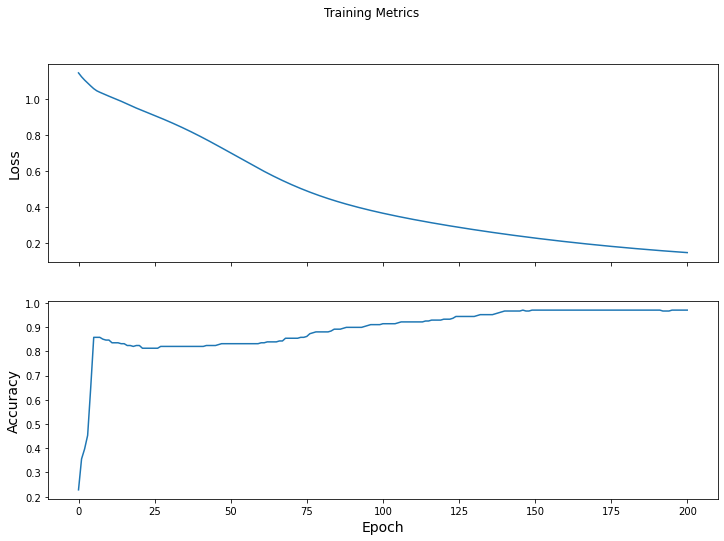

In [20]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

####4. Evaluate the model's effectiveness

In [21]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 98.507%


In [22]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0]])>

###5. Use the trained model to make predictions

In [24]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)
print(predictions)
for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

tf.Tensor(
[[ 2.2400517   0.22641861 -2.1694925 ]
 [-3.3880022  -2.9735768   2.1382267 ]
 [-1.1035311   1.0552406  -2.18539   ]], shape=(3, 3), dtype=float32)
Example 0 prediction: Adélie (87.3%)
Example 1 prediction: Gentoo (99.0%)
Example 2 prediction: Chinstrap (86.6%)
